<a href="https://colab.research.google.com/github/anytaaly/SVM-Predict-HANDWritten-Digits/blob/main/SVM_Predict_HANDWritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Train a support vector machine (SVM) to predict handwritten digits from MNIST dataset.

In [1]:
#################### DO NOT EDIT THE GIVEN IMPORTS ##########################
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

import random
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix
import cv2
import pickle
import numbers

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.filters import gabor_kernel, gabor
from tqdm import tqdm
import time

The MNIST 784 dataset is a well-known collection of 28x28 pixel images of handwritten digits. When you fetch it, x will contain the pixel values (each 28x28 image flattened into a 784-length vector), and y will contain the labels (the digit each image represents). In other words, x is the input data (images) and y is the target labels (the digits 0 through 9).

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


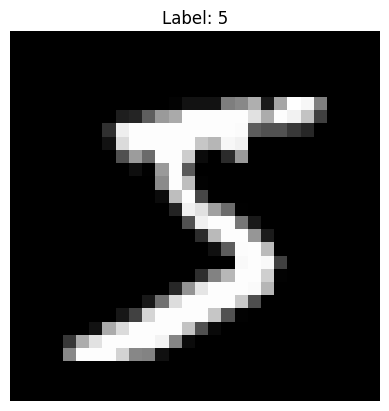

In [2]:

def get_data():
    """
    Complete for subproblem 1a

    Get MNIST data from fetch_openml
    Get data and target converted to numpy
    Call plt.imshow on any random reshaped image to (28,28)
    to see what the digit looks like

    Return:
        x: MNIST image data in numpy
        y: MNIST image target in numpy
    """
    ###TODO: Download mnist 784 dataset, do not specify any parameters except for the dataset name
    #         to be written within the single quotes
    ds = fetch_openml('mnist_784')
    ###TODO: Get the MNIST image data and target, convert to numpy and cast the data into either float or integer!
    x, y = ds.data, ds.target

    # print(ds) #A Bunch is just sklearn’s dictionary-like object.
    print(type(x))  # data is the input features - so x has like list of list, where columns are pixel indexed and rows are each image.
    print(type(y)) # target is the label (the answer, the thing you want to predict).
    x = x.to_numpy().astype(float)
    y = y.to_numpy().astype(int)
    ### TODO: Plot one of the images with plt.imshow
    #...
    image = x[0].reshape(28,28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {y[0]}")
    plt.axis('off')
    return x, y

x,y = get_data();


The reshape and cv2.resize serve two different purposes. First, when you have a flattened image (for example, a 784-length vector for a 28x28 image), you call reshape(28, 28) to turn that flat array into a 2D grid, restoring the original image shape. Then, cv2.resize is used to downsample that 2D image to a smaller size, like 14x14. Finally, after resizing, you call reshape(-1) again to flatten the smaller 14x14 image back into a 196-length vector. In short, you reshape to go from flat to 2D, resize to change the image size, and reshape again to go back to a flat vector.

Sure! Imagine you have an image that’s 4x4 pixels, so it has 16 values. When you store it as a flat array, it’s just a list of numbers, like this:

Flat (1D):
[12, 50, 200, 30,
80, 90, 100, 40,
10, 60, 150, 70,
20, 110, 5, 250]

Now, when you reshape this flat array back into a 2D grid of 4x4, it becomes a matrix, which you can visualize like a little image:

2D (4x4):
[ [12, 50, 200, 30],
[80, 90, 100, 40],
[10, 60, 150, 70],
[20, 110, 5, 250] ]

This 2D form is what functions like cv2.resize() expect, because it’s an image grid—rows and columns of pixel intensities.


In the 2D form, each row represents a horizontal line of pixels in the image. If you think of an image as a grid of pixels, each row is basically one line of that image from left to right. So when you reshape a flattened image back to 2D, you’re reconstructing it row by row—just like how you’d read or display it visually.


 When you plot an image, you need it in that 2D shape so that each row corresponds to a line of pixels in the image. After you’ve downsampled or transformed the image, you reshape it back to a 2D grid, such as 14 by 14. Then, plt.imshow() takes that 2D array and displays it as an image. In short, plt.imshow() is what lets you visually confirm that your downsampled image still looks like a digit!

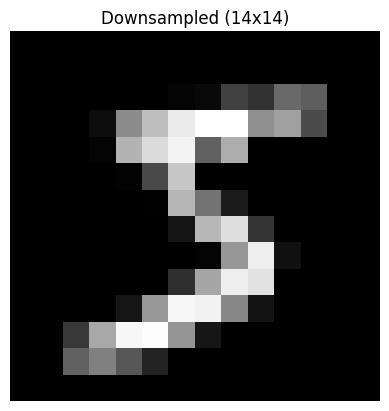

(70000, 784) (70000, 196)


In [3]:
def resize(x, size=(14, 14)):
    """
    Complete for subproblem 1b

    The input arguments are:
    x: numpy array of MNIST data, where each image is of size (28 x 28)
    size(): new data size

    Resize data by calling cv2.resize() for each image from (28 x 28) to (14x14),
    flattened to 196.
    Call plt.imshow to check one of the resized data

    Return: the numpy array of resized, downsampled MNIST data of shape (num_of_images, 196)
    """
    ###TODO###
    num_images = x.shape[0]
    downsampled = np.empty((num_images, size[0] * size[1]), dtype=x.dtype ) ## np.empty() function is a NumPy method that creates an array without initializing its values—so it’s basically a chunk of memory set aside for your data. In the resize function, creating an empty array with the desired shape

    for i in range(num_images):
      img_28 = x[i].reshape(28, 28)
      img_14 = cv2.resize(img_28, (size[1], size[0]),interpolation=cv2.INTER_AREA)
      downsampled[i] = img_14.reshape(-1)


          # Show one resized image to verify
    plt.imshow(downsampled[0].reshape(size[0], size[1]), cmap='gray')
    plt.title("Downsampled (14x14)")
    plt.axis('off')
    plt.show()

    return downsampled


x_small = resize(x, size=(14,14))
print(x.shape, x_small.shape)



In [31]:
def subsample(x, y, num=10000):
    """
    Complete for subproblem 1c

    Create a dataset of 1000 samples for each digit (10,000 samples in total)

    The input arguments are:
    x: MNIST data
    y: MNIST target
    num: Total number of samples required after subsampling

    Return: x_small, y_small subsampled MNIST dataset containing 1,000 images of each digit

    We have 70,000 images and uneven counts per digit - so its not perfectly balanced. class balance affects the hyperplanes

    """
    ### TODO
    x = np.asarray(x)
    y = np.asarray(y, dtype=int).reshape(-1)   # force 1D labels

    # If x is a 1D object array of vectors, stack it into a 2D matrix
    if x.ndim == 1:
        # Try to convert "array of arrays" -> (N, D)
        try:
            x = np.vstack(x)
        except Exception as e:
            raise ValueError(
                f"x must be a 2D array of shape (N, D). Got x.ndim=1 and could not vstack. "
                f"Example element type: {type(x[0])}"
            ) from e

    if x.shape[0] != y.shape[0]:
        raise ValueError(f"x and y have different ## of samples: x={x.shape[0]}, y={y.shape[0]}")

    samples_per_class = num // 10  # 10000 -> 1000 per digit

    x_list = []
    y_list = []

    for digit in range(10):
        idx = np.where(y == digit)[0]
        # added on Jeans recommendation
        if len(idx) < samples_per_class:
            raise ValueError(f"Digit {digit} has less than {samples_per_class} samples.")
        chosen = np.random.choice(idx, samples_per_class, replace=False)
        x_list.append(x[chosen])
        y_list.append(y[chosen])

    x_small = np.vstack(x_list)     # (10000, D)
    y_small = np.hstack(y_list)     # (10000,)

    # Debugging: Print shapes and dtype before shuffling - Jean recommendation
    print("x_small shape before shuffle:", x_small.shape)
    print("y_small shape before shuffle:", y_small.shape)
    print("y_small dtype:", y_small.dtype)
    print("DEBUG subsample:")
    print("x_small shape:", x_small.shape)
    print("y_small shape:", y_small.shape)
    print("x_small dtype:", x_small.dtype)
    print("y_small dtype:", y_small.dtype)

    #shuffle code
    perm = np.random.permutation(y_small.shape[0])  # 10000 indices
    x_small = x_small[perm]
    y_small = y_small[perm]

    return x_small, y_small


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
x shape: (70000, 784)
y shape: (70000,)


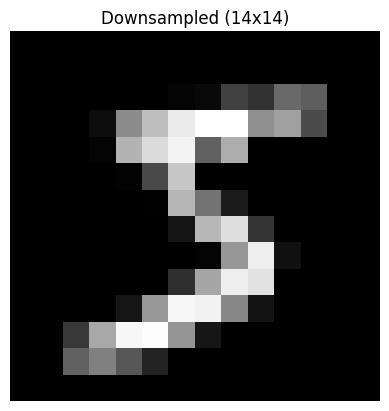

x_resized shape: (70000, 196)
x_small shape before shuffle: (10000, 196)
y_small shape before shuffle: (10000,)
y_small dtype: int64
DEBUG subsample:
x_small shape: (10000, 196)
y_small shape: (10000,)
x_small dtype: float64
y_small dtype: int64
x_sub shape: (10000, 196)
y_sub shape: (10000,)
Class distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
2
1
perm max: 9999


In [33]:
x,y = get_data();
print("x shape:", x.shape)  #  (70000, 784)
print("y shape:", y.shape)  #  (70000,)

x_resized = resize(x);
print("x_resized shape:", x_resized.shape)  #  (70000, 196) - still have 70,000 images but now tye are compressed

x_out,y_out = subsample(x_resized,y);
print("x_sub shape:", x_sub.shape)  # Should be (10000, 196)
print("y_sub shape:", y_sub.shape)  # Should be (10000,)
print("Class distribution:", np.bincount(y_sub))  # 1000 per class

assert x_out.shape[0] == 10000
assert y_out.shape[0] == 10000
print(len(x_out.shape))
print(len(y_out.shape))

# Generate permutation
perm = np.random.permutation(y_out.shape[0])
print("perm max:", perm.max())


In [29]:

def data_preprocessing(x,y):
    """
    Complete for subproblem 1d

    x: numpy array of MNIST data
    y: numpy array of MNIST targets

    Sub-sample data using the provided subsample method,
    to have equal number of data for each digit
    Resize data to (14,14)
    Get train and validation split with random state 42, test size 0.2 (since we want 20% as validation set), shuffled, and stratified

    Return: x_train, x_val, y_train, y_val
    """
    ###TODO###
    x_small, y_small = subsample(x, y, num=10000)
    x_small = resize(x_small, size=(14, 14))

    x_train, x_val, y_train, y_val = train_test_split(
        x_small, y_small,
        test_size=0.2,
        random_state=42,
        shuffle=True,
        stratify=y_small
    )
    return x_train, x_val, y_train, y_val


In [34]:
def get_number_of_support_samples(clf):
    """

    Complete for 1e

    The input argument is the SVC classifier

    Check the SVC documentation for how to get the total
    number of support vectors of the classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

    Return: Total number of support samples given the classifier
    Support vectors are the data points that lie closest to the decision boundary.
    """
    return np.sum(clf.n_support_)

In [24]:
def train_test_SVM(x_train, y_train, x_val, y_val):
    """
    Train/test an SVM model given training and validation data.
    Print:
      - validation accuracy
      - validation error
      - confusion matrix
      - support sample ratio (%)
    Return: val_acc, cm, supp_vector_percent
    """

    # 1) Initialize classifier (reasonable baseline)
    clf = svm.SVC(kernel="rbf", C=10, gamma="scale")

    # 2) Fit
    clf.fit(x_train, y_train)

    # 3) Predict + accuracy
    y_pred = clf.predict(x_val)
    val_acc = clf.score(x_val, y_val)
    val_err = 1 - val_acc

    # 4) Confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # 5) Support vector ratio
    num_support = get_number_of_support_samples(clf)
    supp_vector_percent = (num_support / x_train.shape[0]) * 100

    # 6) Printt the outputs
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Error:    {val_err:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Support Vectors: {num_support} / {x_train.shape[0]} ({supp_vector_percent:.2f}%)")

    return val_acc, cm, supp_vector_percent


Hyperparameter Tuning - Instead of manually guessing which combination of kernel, C, and gamma works best, GridSearchCV function automatically tries all possible combinations and finds the one that gives the highest accuracy.

In [39]:
def grid_search_SVM(x_train, y_train, x_val, y_val, params):
    """

    Complete for 1g

    Perform grid search to find the best classifier
    Get the following values:
    - best accuracy for training data
    - best estimators of each parameter
    - accuracy of hyperparameters tried
    Look at the documentation for GridSearchCV to get the values above
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

    Get the best classifier found by grid search to get predicted y_val

    Print the confusion matrix given the true y_val and predicted y_val

    Return: best classifier found by grid search

    """

    # Base estimator (params will override via GridSearchCV)
    base = svm.SVC()

    clf = GridSearchCV(
        estimator=base,
        param_grid=params,
        scoring="accuracy",
        cv=3,            # common default; change if your HW specifies
        n_jobs=-1,
        refit=True
    )

    clf.fit(x_train, y_train)

    # 1) Best CV accuracy on training folds
    best_score = clf.best_score_
    if isinstance(best_score, numbers.Number):
        print(f"Best CV Accuracy (train folds): {best_score:.4f}")
    else:
        print(f"Best CV Accuracy (train folds): {best_score}")

    # 2) Best parameters
    print("Best Parameters:")
    print(clf.best_params_)

    # 3) Accuracy for each hyperparameter setting tried
    # (mean test score across CV folds for each parameter combo)
    mean_scores = clf.cv_results_["mean_test_score"]
    params_tried = clf.cv_results_["params"]

    # print("\nHyperparameter results (mean CV accuracy):")
    for p, s in sorted(zip(params_tried, mean_scores), key=lambda t: t[1], reverse=True):
        if isinstance(s, numbers.Number):
            print(f"{s:.4f}  ->  {p}")
        else:
            print(f"{s}  ->  {p}")

    # Use best estimator to predict validation set and print confusion matrix
    best_model = clf.best_estimator_
    y_pred_val = best_model.predict(x_val)
    cm = confusion_matrix(y_val, y_pred_val)

    print("\nValidation Confusion Matrix (best model):")
    print(cm)

    return best_model


x_small shape before shuffle: (10000, 784)
y_small shape before shuffle: (10000,)
y_small dtype: int64
DEBUG subsample:
x_small shape: (10000, 784)
y_small shape: (10000,)
x_small dtype: float64
y_small dtype: int64


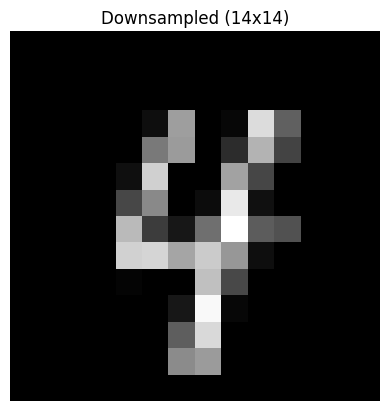

Best CV Accuracy (train folds): 0.9614
Best Parameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.9614  ->  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.9539  ->  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.9184  ->  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.8946  ->  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
0.8946  ->  {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
0.8946  ->  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.8946  ->  {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
0.8946  ->  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.8946  ->  {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
0.1158  ->  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.1158  ->  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.1156  ->  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

Validation Confusion Matrix (best model):
[[197   0   1   0   0   2   0   0   0   0]
 [  0 195   1   2   1   0   0   0   1   0]
 [  1   1 192   1   0   0   0   3   2   0]
 [  0   0   1 193   0   2   0  

In [40]:
# Example parameter grid (you can adjust based on what you need to test)
params = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Types of kernel
    'gamma': ['scale', 'auto']  # Kernel coefficient for ‘rbf’
}
x_train, x_val, y_train, y_val = data_preprocessing(x, y)
# Assume x_train, y_train, x_val, y_val are already defined
best_model = grid_search_SVM(x_train, y_train, x_val, y_val, params)

# The function will print:
# - Best CV accuracy
# - Best parameters
# - Mean accuracy for each parameter combo
# - Confusion matrix on validation set

# You can also access the best estimator directly if needed
print("Best model:", best_model)

In [27]:
def apply_gfilter(images, frequency_list, theta_list, bandwidth_list):
    """
    Return:
        gabor_real_coeffs: np.array of shape (num_images, n_filters * 14 * 14)
    """

    # images should be (N, 196) for 14x14 flattened
    num_images = images.shape[0]
    pixels = images.shape[1]  # should be 196

    n_filters = len(frequency_list) * len(theta_list) * len(bandwidth_list)
    gabor_real_coeffs = np.empty((num_images, n_filters * pixels), dtype=np.float32)

    for i in tqdm(range(num_images)):
        img_2d = images[i].reshape(14, 14).astype(np.float32)

        feats = []
        for freq in frequency_list:
            for theta in theta_list:
                for bw in bandwidth_list:
                    real, imag = gabor(img_2d, frequency=freq, theta=theta, bandwidth=bw)
                    feats.append(real.reshape(-1))  # length 196

        gabor_real_coeffs[i] = np.concatenate(feats, axis=0)

    # sanity checks required by your skeleton
    assert gabor_real_coeffs.shape[0] == len(images)
    assert gabor_real_coeffs.shape[1] == n_filters * images.shape[1]

    return gabor_real_coeffs

In [29]:
def gabor_filter(x_train, y_train, x_val, y_val):
    """
    Perform gabor filter experiment
    """

    # 1. Prepare a balanced 1,000 training and validation images
    #     of 100 images per class
    ### TODO ###
    x_tr, y_tr = subsample(x_train, y_train, num=1000)  # 100 per class
    x_va, y_va = subsample(x_val, y_val, num=1000)


    # 2. Check gabor kernel and gabor outputs as example
    ### TODO ###
    # Visualize example Gabor kernel + convolution
    freq = 0.1
    theta = np.pi / 4
    bandwidth = 1
    gk = gabor_kernel(frequency=freq, theta=theta, bandwidth=bandwidth)

    plt.figure(); plt.imshow(gk.real); plt.title("Gabor Kernel (Real)"); plt.axis("off")
    plt.figure(); plt.imshow(gk.imag); plt.title("Gabor Kernel (Imag)"); plt.axis("off")

    img = x_tr[0].reshape(14, 14)
    coeff_real, coeff_imag = gabor(img, frequency=freq, theta=theta, bandwidth=bandwidth)

    plt.figure(); plt.imshow(coeff_real); plt.title("Gabor Output (Real)"); plt.axis("off")
    plt.figure(); plt.imshow(img); plt.title("Original Image"); plt.axis("off")


    assert x_tr.shape[1] == 196, f"Expected 196 features (14x14), got {x_tr.shape[1]}"
    assert x_va.shape[1] == 196,   f"Expected 196 features (14x14), got {x_va.shape[1]}"

    # 3. Diversify the values for frequency, theta, and bandwidth parameters
    #    Plot 8 pairs of real and imaginary coefficients from gabor_kernel()
    #    to check diversity of this filter-bank
    ### TODO ###
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
    frequency_list = [0.05, 0.25]
    bandwidth_list = [0.1, 1]
    k = 0
    count = 0
    for f in frequency_list:
        for t in theta_list:
            for b in bandwidth_list:
                if count >= 8:
                    break
                gk = gabor_kernel(frequency=f, theta=t, bandwidth=b)
                plt.figure(); plt.imshow(gk.real); plt.title(f"Kernel {count+1} Real"); plt.axis("off")
                plt.figure(); plt.imshow(gk.imag); plt.title(f"Kernel {count+1} Imag"); plt.axis("off")
                count += 1


    # 4. Obtain new training and validation datasets of real coefficients
    #    by calling apply_gfilter() function
    ### TODO ###
    Xg_train = apply_gfilter(x_tr, frequency_list, theta_list, bandwidth_list)
    Xg_val   = apply_gfilter(x_va, frequency_list, theta_list, bandwidth_list)


    # 5. Standardize and then PCA features with StandardScaler() and PCA() functions
    ### TODO ###
    scaler = StandardScaler()
    Xg_train = scaler.fit_transform(Xg_train)
    Xg_val   = scaler.transform(Xg_val)

    pca = PCA(n_components=200, random_state=42)
    Xg_train = pca.fit_transform(Xg_train)
    Xg_val   = pca.transform(Xg_val)

    # 6. Find best svm.SVC classifier
    #    Hint: look into cache_size parameter of svm.SVC() to speed up training
    ### TODO ###
    clf = svm.SVC(kernel="rbf", C=10, gamma="scale", cache_size=2000)
    clf.fit(Xg_train, y_tr)

    val_acc = clf.score(Xg_val, y_va)
    print(f"Gabor-SVM Validation Accuracy: {val_acc:.4f}")

    classifier = clf
    return classifier

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


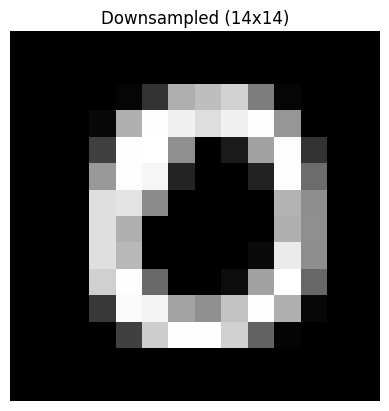

train: (8000, 196) (8000,)
val:   (2000, 196) (2000,)
counts train: [800 800 800 800 800 800 800 800 800 800]
counts val:   [200 200 200 200 200 200 200 200 200 200]
Validation Accuracy: 0.9610
Validation Error:    0.0390
Confusion Matrix:
[[194   0   3   0   0   1   1   0   1   0]
 [  0 195   1   0   0   0   1   1   2   0]
 [  1   1 191   2   0   0   0   5   0   0]
 [  0   0   1 189   0   8   0   0   2   0]
 [  0   0   0   0 194   1   1   0   0   4]
 [  0   0   1   6   4 182   3   0   3   1]
 [  0   0   0   0   0   0 200   0   0   0]
 [  0   1   0   0   4   0   0 192   0   3]
 [  1   3   0   2   0   2   1   0 190   1]
 [  0   1   0   0   2   0   0   1   1 195]]
Support Vectors: 2727 / 8000 (34.09%)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best CV Accuracy (train folds): 0.9635
Best Parameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Hyperparameter results (mean CV accuracy):
0.9635  ->  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.9572  ->  {'C': 1, 'gamma'

 24%|██▎       | 236/1000 [1:26:51<4:41:37, 22.12s/it]

In [ ]:
if __name__ == '__main__':
    ### TODO: get downloaded MNIST data and target
    x, y = get_data();

    ### TODO: preprocess the data
    x_train, x_val, y_train, y_val = data_preprocessing(x, y)

    print("train:", x_train.shape, y_train.shape)
    print("val:  ", x_val.shape, y_val.shape)
    print("counts train:", np.unique(y_train, return_counts=True)[1])
    print("counts val:  ", np.unique(y_val, return_counts=True)[1])

    # train_test_SVM(x_train, y_train, x_val, y_val)
    val_acc, cm, sv_percent = train_test_SVM(x_train, y_train, x_val, y_val)

    # ### TODO: define SVM hyperparameters to perform grid search with
    params = {
        "kernel": ["linear", "rbf"],
        "C": [0.1, 1, 10],
        "gamma": ["scale", 0.01, 0.001]
    }
    # ### TODO: Save the best svm classifier returned by grid_search_SVM to pickle file
    best_svm = grid_search_SVM(x_train, y_train, x_val, y_val, params)
    with open("grid_search_svm.pkl", "wb") as f:
        pickle.dump(best_svm, f)
    print("Saved best grid-search SVM to grid_search_svm.pkl")

    # ### TODO: gabor_filter() and apply_gfilter()
    # ...
    gabor_clf = gabor_filter(x_train, y_train, x_val, y_val)

    # Explicit apply_gfilter() call in main (if your assignment insists)
    theta_list = [np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
    frequency_list = [0.05, 0.25]
    bandwidth_list = [0.1, 1]

    # Use a small balanced subset for a quick check (100 per class)
    x_demo, y_demo = subsample(x_train, y_train, num=1000)
    Xg_demo = apply_gfilter(x_demo, frequency_list, theta_list, bandwidth_list)
    print("apply_gfilter demo output shape:", Xg_demo.shape)